# Response_2: feature engineering

### Table of Contents
- [1. Load Data](#1-load-data)  


- [2. Features analysis](#3-features-analysis)  
    - [2.1 Autocorrelation](#31-autocorrelation)
    - [2.2 Grammer error](#31-grammer-error)  



In [105]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

### 1. Load data

In [80]:
df = pd.read_csv('datasets/feature_extraction.csv')
df.head()

,Unnamed: 0,response,score,response_length,grammer_error,response_corrected,readability,type_token_ratio,mean_sentence_length,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,0,"During my journey, I faced a big health proble...",3,110,0.000000,"During my journey, I faced a big health proble...",78.28,0.647541,20.333333,0.487087,0.999572,1,1,1,1
1,1,i once had a big problem when i wasn't ready f...,3,70,0.114286,I once had a big problem when I wasn't ready f...,91.11,0.765432,16.200000,0.321876,-0.986382,1,1,1,1
2,2,During my junior year I faced a significant ch...,3,135,0.014815,During my junior year I faced a significant ch...,-65.56,0.678832,137.000000,0.000000,0.995565,2,1,2,1
3,3,"Once, I encountered a situation that was quite...",2,109,0.000000,"Once, I encountered a situation that was quite...",47.18,0.684211,19.000000,0.308484,0.994910,1,1,1,1
4,4,"during a trip, i suffered a serious accident t...",3,53,0.113208,"During a trip, I suffered a serious accident t...",49.52,0.721311,15.250000,0.434561,-0.989042,2,1,1,1


In [81]:
columns = df.columns.tolist()
target_columns = [col for col in columns if col not in ['Unnamed: 0','response','response_corrected', 'gpt_scores']]
target_df = df[target_columns]
target_df.head()

,score,response_length,grammer_error,readability,type_token_ratio,mean_sentence_length,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,3,110,0.000000,78.28,0.647541,20.333333,0.487087,0.999572,1,1,1,1
1,3,70,0.114286,91.11,0.765432,16.200000,0.321876,-0.986382,1,1,1,1
2,3,135,0.014815,-65.56,0.678832,137.000000,0.000000,0.995565,2,1,2,1
3,2,109,0.000000,47.18,0.684211,19.000000,0.308484,0.994910,1,1,1,1
4,3,53,0.113208,49.52,0.721311,15.250000,0.434561,-0.989042,2,1,1,1


In [108]:
target_df.to_csv('datasets/feature_target.csv')

### 2. Features analysis

#### 2.1. Autocorrelation

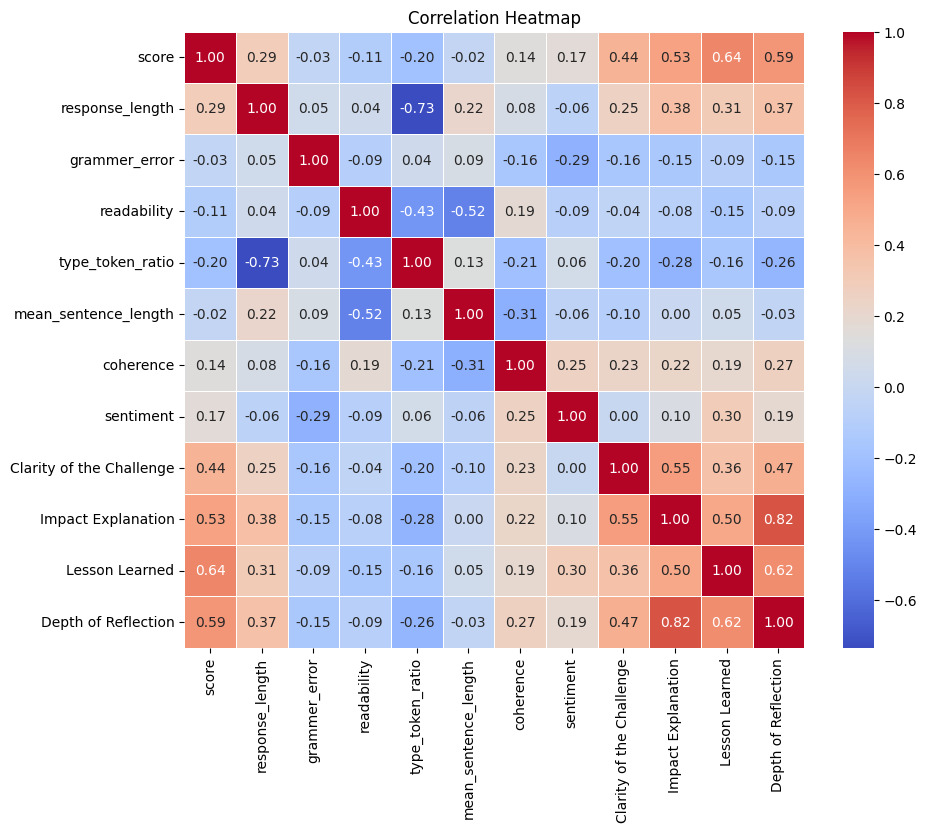

In [82]:
corr_matrix = target_df.corr(method='spearman')  # Change to 'spearman' or 'kendall' if needed

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [95]:
correlation_plot_df = corr_matrix[['score']]
correlation_plot_df = correlation_plot_df.iloc[1:,:]

In [96]:
chart = alt.Chart(correlation_plot_df.reset_index()).mark_bar().encode(
    x=alt.X('index:N', sort='-y', title='', 
        axis=alt.Axis(labelFontSize=12)  # Bigger x-axis labels, horizontal orientation
    ),
    y=alt.Y('score:Q', title='Spearman Correlation', 
        axis=alt.Axis(domain=False, grid=False)  # Remove y-axis line & grid
    ),
    color=alt.Color('score:Q', 
        scale=alt.Scale(scheme='blueorange', domainMid=0),  # Cold-Warm color mapping
        legend=None
    )
).properties(
    width=600, height=300  # Bigger chart for better readability
)

text = alt.Chart(correlation_plot_df.reset_index()).mark_text(
    align='center',
    baseline='middle',
    dy=-10,  # Adjust text position
    fontSize=12,  # Bigger text
    color='black'
).encode(
    x=alt.X('index:N', sort='-y', 
        axis=alt.Axis(labelFontSize=12)  # Match bigger x-axis labels
    ),
    y=alt.Y('score:Q'),
    text=alt.Text('score:Q', format=".2f")  # Format to 2 decimal places
)

chart + text



alt.LayerChart(...)

**Comments**:
- **`Linguistic Quality`** is removed, since there's no variance in this feature. 


#### 2.2 Grammer error

**Comments**

Surprisingly, our analysis revealed a minimal correlation between the score and grammar errors. We will conduct further investigation to better understand this relationship.

In [106]:
def kde_density_plot(scores, color):
    # Compute KDE
    kde = gaussian_kde(scores, bw_method='scott')  # Bandwidth selection method
    x_values = np.linspace(min(scores) - 0.1, max(scores) + 0.1, 100)
    pdf_values = kde(x_values)

    # Create DataFrames
    raw_df = pd.DataFrame({'value': scores, 'height': 0})
    df_pdf = pd.DataFrame({'x': x_values, 'pdf': pdf_values})

    # Scatter plot for raw data points
    dist_chart = alt.Chart(raw_df).mark_circle(color=color).encode(
        x=alt.X('value', scale=alt.Scale(domain=[min(scores) - 0.1, max(scores) + 0.1])),
        y=alt.Y('height', title=''),
    ).properties(width=500, height=50)

    # KDE curve
    pdf_chart = alt.Chart(df_pdf).mark_line(color=color).encode(
        x=alt.X('x', scale=alt.Scale(domain=[min(scores) - 0.1, max(scores) + 0.1])),
        y=alt.Y('pdf:Q', scale=alt.Scale(domain=[0, df_pdf['pdf'].max()])),
    ).properties(width=500, height=50)

    return dist_chart + pdf_chart

In [107]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']
charts = []
for i in range(1,6):
    score_df = df[df['score']==i]
    scores = score_df['grammer_error']
    charts.append(kde_density_plot(scores, colors[i-1]))

overall_chart = charts[4]&charts[3]&charts[2]&charts[1]&charts[0]
overall_chart

alt.VConcatChart(...)

In [7]:
columns

['Unnamed: 0',
 'response',
 'score',
 'response_length',
 'grammer_error',
 'response_corrected',
 'readability',
 'type_token_ratio',
 'mean_sentence_length',
 'coherence',
 'sentiment',
 'gpt_scores',
 'Relevance',
 'Completeness',
 'Depth of Reflection',
 'Response Quality',
 'Linguistic Quality']

In [ ]:
def fined_normal_pdf(scores, color):
    mu, sigma = norm.fit(scores)
    x_values = np.linspace(15, 270, 100)  # 100 points for smooth curve
    pdf_values = norm.pdf(x_values, mu, sigma)
    raw_df = pd.DataFrame({'value':scores})
    raw_df['height'] = 0
    df_pdf = pd.DataFrame({'x': x_values, 'pdf': pdf_values})
    
    dist_chart = alt.Chart(raw_df).mark_circle(color=color).encode(
        x=alt.X('value',scale=alt.Scale(domain=[15, 270])),
        y='height'
    ).properties(
        width=500, height=50
    )
    pdf_chart = alt.Chart(df_pdf).mark_line(color=color).encode(
        x=alt.X('x',scale=alt.Scale(domain=[15, 270])),
        y=alt.Y('pdf:Q', scale=alt.Scale(domain=[0, df_pdf['pdf'].max()])),
    ).properties(
        width=500, height=50
    )
    return dist_chart+pdf_chart

In [1]:
def fined_boxplot(scores, color):
    raw_df = pd.DataFrame({'value':scores})
    boxplot = alt.Chart(raw_df).mark_boxplot(color=color).encode(
        x=alt.X('value', scale=alt.Scale(domain=[15, 270]), axis=None)
    ).properties(
        width=500, height=50
    )
    return boxplot

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']
charts = []
for i in range(1,6):
    score_df = df[df['score']==i]
    scores = score_df['response_length']
    charts.append(fined_normal_pdf(scores, colors[i-1]))

In [ ]:
overall_chart = charts[4]&charts[3]&charts[2]&charts[1]&charts[0]
overall_chart

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']
charts = []
for i in range(1,6):
    score_df = df[df['score']==i]
    scores = score_df['response_length']
    charts.append(fined_boxplot(scores, colors[i-1]))

overall_chart_1 = charts[4]&charts[3]&charts[2]&charts[1]&charts[0]
overall_chart_1